<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1">Import</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2">Загрузка данных</a></span></li><li><span><a href="#Keras-model-creation" data-toc-modified-id="Keras-model-creation-3">Keras model creation</a></span><ul class="toc-item"><li><span><a href="#AGE_model" data-toc-modified-id="AGE_model-3.1">AGE_model</a></span><ul class="toc-item"><li><span><a href="#AGE-ImageDataGenerator" data-toc-modified-id="AGE-ImageDataGenerator-3.1.1">AGE ImageDataGenerator</a></span></li><li><span><a href="#AGE-Fit-model" data-toc-modified-id="AGE-Fit-model-3.1.2">AGE Fit model</a></span></li><li><span><a href="#AGE-Визуализация-истории-обучения-сети" data-toc-modified-id="AGE-Визуализация-истории-обучения-сети-3.1.3">AGE Визуализация истории обучения сети</a></span></li></ul></li><li><span><a href="#GENDER_model" data-toc-modified-id="GENDER_model-3.2">GENDER_model</a></span><ul class="toc-item"><li><span><a href="#GENDER-ImageDataGenerator" data-toc-modified-id="GENDER-ImageDataGenerator-3.2.1">GENDER ImageDataGenerator</a></span></li><li><span><a href="#GENDER-Fit-model" data-toc-modified-id="GENDER-Fit-model-3.2.2">GENDER Fit model</a></span></li><li><span><a href="#GENDER-Визуализация-истории-обучения-сети" data-toc-modified-id="GENDER-Визуализация-истории-обучения-сети-3.2.3">GENDER Визуализация истории обучения сети</a></span></li></ul></li><li><span><a href="#Evaluate-models" data-toc-modified-id="Evaluate-models-3.3">Evaluate models</a></span></li><li><span><a href="#Predict-model" data-toc-modified-id="Predict-model-3.4">Predict model</a></span></li></ul></li></ul></div>

# Import

In [1]:
import os
import cv2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
np.random.seed(42)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers
from tensorflow.keras import utils
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import keras_tuner
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

tf.random.set_seed(42)

# Загрузка данных

In [3]:
x_train = np.load('train_val_test/x_train.npy')
x_val = np.load('train_val_test/x_val.npy')
x_test = np.load('train_val_test/x_test.npy')

y_train_age = np.load('train_val_test/y_train_age.npy')
y_val_age = np.load('train_val_test/y_val_age.npy')
y_test_age = np.load('train_val_test/y_test_age.npy')

y_train_gen = np.load('train_val_test/y_train_gen.npy')
y_val_gen = np.load('train_val_test/y_val_gen.npy')
y_test_gen = np.load('train_val_test/y_test_gen.npy')

print(f'AGE: x_train: {x_train.shape}, y_train_age: {y_train_age.shape}\n\
     x_val:    {x_val.shape}, y_val_age:    {y_val_age.shape}\n\
     x_test:   {x_test.shape}, y_test_age:   {y_test_age.shape}')
print('')
print(f'GENDER: x_train: {x_train.shape}, y_train_gen: {y_train_gen.shape}\n\
        x_val:   {x_val.shape},  y_val_gen:    {y_val_gen.shape}\n\
        x_test:  {x_test.shape},  y_test_gen:   {y_test_gen.shape}')


AGE: x_train: (14396, 64, 64, 1), y_train_age: (14396,)
     x_val:    (3600, 64, 64, 1), y_val_age:    (3600,)
     x_test:   (4499, 64, 64, 1), y_test_age:   (4499,)

GENDER: x_train: (14396, 64, 64, 1), y_train_gen: (14396,)
        x_val:   (3600, 64, 64, 1),  y_val_gen:    (3600,)
        x_test:  (4499, 64, 64, 1),  y_test_gen:   (4499,)


# Keras model creation

## AGE_model

In [4]:
# Размеры изображения
img_width, img_height, cannels = x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2]
# Размерность тензора для входных данных в нейронную сеть
input_shape = (img_width, img_height, cannels)
# Количество эпох
epochs = 100
# Размер мини-выборки
batch_size = 64
# Путь сохранения модели
model_path = 'age_model_UTKFace.h5'

print('img_width, img_height, cannels:', img_width,',', img_height,',', cannels)
print('input_shape:', input_shape)

img_width, img_height, cannels: 64 , 64 , 1
input_shape: (64, 64, 1)


In [28]:
def age_model():
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = layers.Conv2D(96,3,activation='relu')(inputs)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(176,3,activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(416,3,activation='relu')(x)
    x = layers.MaxPool2D(2)(x)

    x = layers.Conv2D(512,3,activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs_age = layers.Dense(1,activation='relu',name='age_out')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs_age)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])
    
    tf.keras.utils.plot_model(model, 'age_model.png',show_shapes=True)  
    return model


age_model=age_model()

# Image('age_model.png')

In [29]:
age_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 176)       152240    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 176)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 416)       659360

### AGE ImageDataGenerator

In [30]:
y_train_age = y_train[:,0]
y_val_age = y_val[:,0]

datagen_age = ImageDataGenerator(rescale=1./255., 
                                 rotation_range = 20,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range = 0.1,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

train_age = datagen_age.flow(x_train, y_train_age, batch_size=batch_size)

val_datagen_age = ImageDataGenerator(rescale=1./255., 
                                     rotation_range = 20,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     shear_range = 0.1,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

val_age = val_datagen_age.flow(x_val, y_val_age, batch_size=batch_size)


### AGE Fit model

In [31]:
%%time

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)
                

checkpointer = ModelCheckpoint(model_path,
                               monitor = 'loss',
                               verbose = 1, 
                               save_best_only = True,
                               save_weights_only = False, 
                               mode = 'auto',
                               save_freq = 'epoch')                

callbacks_list = [checkpointer, earlystop]

age_model_history = age_model.fit(train_age, epochs=epochs, shuffle=True, 
                                  validation_data=val_age, callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 876.5386 - mae: 23.5958
Epoch 00001: loss improved from inf to 876.53864, saving model to age_model_UTKFace.h5
225/225 [==============================] - 244s 1s/step - loss: 876.5386 - mae: 23.5958 - val_loss: 700.3368 - val_mae: 20.5960
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 331.6738 - mae: 14.0333
Epoch 00002: loss improved from 876.53864 to 331.67380, saving model to age_model_UTKFace.h5
225/225 [==============================] - 251s 1s/step - loss: 331.6738 - mae: 14.0333 - val_loss: 391.3776 - val_mae: 15.1303
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 257.6549 - mae: 12.2921
Epoch 00003: loss improved from 331.67380 to 257.65491, saving model to age_model_UTKFace.h5
225/225 [==============================] - 218s 967ms/step - loss: 257.6549 - mae: 12.2921 - val_loss: 271.8112 - val_mae: 13.0818
Epoch 4/100
225/225 [==============================] - 

Epoch 27/100
225/225 [==============================] - ETA: 0s - loss: 108.7107 - mae: 7.8498
Epoch 00027: loss improved from 111.93387 to 108.71075, saving model to age_model_UTKFace.h5
225/225 [==============================] - 232s 1s/step - loss: 108.7107 - mae: 7.8498 - val_loss: 191.7351 - val_mae: 11.1246
Epoch 28/100
225/225 [==============================] - ETA: 0s - loss: 107.7508 - mae: 7.8474
Epoch 00028: loss improved from 108.71075 to 107.75076, saving model to age_model_UTKFace.h5
225/225 [==============================] - 233s 1s/step - loss: 107.7508 - mae: 7.8474 - val_loss: 115.7474 - val_mae: 8.3545
Epoch 29/100
225/225 [==============================] - ETA: 0s - loss: 108.1046 - mae: 7.8170
Epoch 00029: loss did not improve from 107.75076
225/225 [==============================] - 233s 1s/step - loss: 108.1046 - mae: 7.8170 - val_loss: 174.7872 - val_mae: 10.4334
Epoch 30/100
225/225 [==============================] - ETA: 0s - loss: 104.6530 - mae: 7.6987
Epoch

### AGE Визуализация истории обучения сети

In [33]:
print(age_model_history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


''

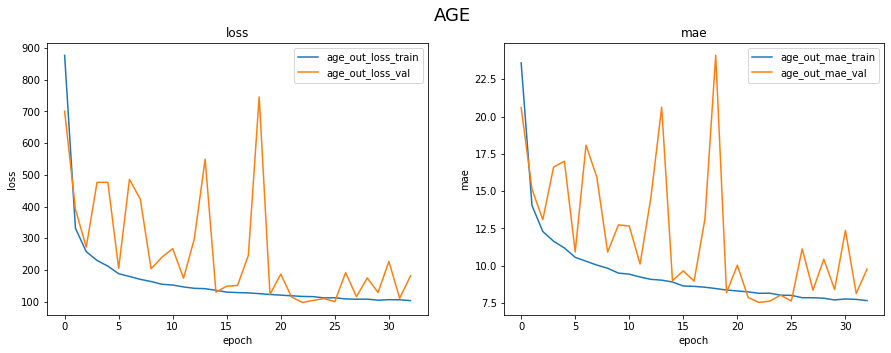

In [34]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('AGE', fontsize=18)

# loss age    
subplot = fig.add_subplot(1, 2, 1)
plt.plot(age_model_history.history['loss'], label='age_out_loss_train')
plt.plot(age_model_history.history['val_loss'], label='age_out_loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('loss')

# mae age
subplot = fig.add_subplot(1, 2, 2)
plt.plot(age_model_history.history['mae'], label='age_out_mae_train')
plt.plot(age_model_history.history['val_mae'], label='age_out_mae_val')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()
plt.title('mae')
;

## GENDER_model

In [35]:
# Параметры gen_model

# Размеры изображения
img_width, img_height, cannels = x_train[0].shape[0], x_train[0].shape[1], x_train[0].shape[2]
# Размерность тензора для входных данных в нейронную сеть
input_shape = (img_width, img_height, cannels)
# Количество эпох
epochs = 100
# Размер мини-выборки
batch_size = 64
# Путь сохранения модели
model_path = 'gen_model_UTKFace.h5'

print('img_width, img_height, cannels:', img_width,',', img_height,',', cannels)
print('input_shape:', input_shape)

img_width, img_height, cannels: 64 , 64 , 1
input_shape: (64, 64, 1)


In [36]:
def gen_model():
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    x = layers.Conv2D(48,3,activation='relu')(inputs)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(240,3,activation='relu')(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(480,3,activation='relu')(x)
    x = layers.MaxPool2D(2)(x)

    x = layers.Flatten()(x)

    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(416,activation='relu')(x)
    
    x = layers.Dropout(0.6)(x)
    
    outputs_gender = layers.Dense(2,activation='softmax',name='gender_out')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs_gender)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    tf.keras.utils.plot_model(model, 'gen_model.png',show_shapes=True)  
    return model

gen_model=gen_model()

# Image('gen_model.png')

In [37]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 48)        480       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 240)       103920    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 240)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 480)       1037

### GENDER ImageDataGenerator

In [38]:
y_train_gen = tf.keras.utils.to_categorical(y_train[:,1], num_classes=2)
y_val_gen = tf.keras.utils.to_categorical(y_val[:,1], num_classes=2)

datagen_gen = ImageDataGenerator(rescale=1./255., 
                                 rotation_range = 20,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range = 0.1,
                                 zoom_range = 0.2,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest') 

train_gender = datagen_gen.flow(x_train, y_train_gen, batch_size=batch_size)

val_datagen_gender = ImageDataGenerator(rescale=1./255., 
                                        rotation_range = 20,
                                        width_shift_range = 0.1,
                                        height_shift_range = 0.1,
                                        shear_range = 0.1,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        fill_mode = 'nearest')

val_gender = val_datagen_gender.flow(x_val, y_val_gen, batch_size=batch_size)

### GENDER Fit model

In [39]:
%%time

epochs = 100
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)
                
checkpointer = ModelCheckpoint(model_path,
                               monitor = 'loss',
                               verbose = 1, 
                               save_best_only = True,
                               save_weights_only = False, 
                               mode = 'auto',
                               save_freq = 'epoch')                

# tensorboard = TensorBoard(log_dir='tb_logs', histogram_freq=1, write_images=True)
callbacks_list = [checkpointer, earlystop]  #, tensorboard]

gen_model_history = gen_model.fit(train_gender, epochs=epochs, shuffle=True,
                                  validation_data=val_gender, callbacks=callbacks_list)

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7218
Epoch 00001: loss improved from inf to 0.56062, saving model to gen_model_UTKFace.h5
225/225 [==============================] - 162s 717ms/step - loss: 0.5606 - accuracy: 0.7218 - val_loss: 0.6467 - val_accuracy: 0.6822
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7854
Epoch 00002: loss improved from 0.56062 to 0.46202, saving model to gen_model_UTKFace.h5
225/225 [==============================] - 164s 729ms/step - loss: 0.4620 - accuracy: 0.7854 - val_loss: 0.5335 - val_accuracy: 0.7775
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8171
Epoch 00003: loss improved from 0.46202 to 0.41275, saving model to gen_model_UTKFace.h5
225/225 [==============================] - 170s 754ms/step - loss: 0.4127 - accuracy: 0.8171 - val_loss: 0.4275 - val_accuracy: 0.7997
Epoch 4/100
225/225 [====================

Epoch 27/100
225/225 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9071
Epoch 00027: loss did not improve from 0.23415
225/225 [==============================] - 174s 774ms/step - loss: 0.2351 - accuracy: 0.9071 - val_loss: 0.2198 - val_accuracy: 0.9106
Epoch 28/100
225/225 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9071
Epoch 00028: loss did not improve from 0.23415
225/225 [==============================] - 176s 784ms/step - loss: 0.2351 - accuracy: 0.9071 - val_loss: 0.2254 - val_accuracy: 0.9036
Epoch 29/100
225/225 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9070
Epoch 00029: loss improved from 0.23415 to 0.22948, saving model to gen_model_UTKFace.h5
225/225 [==============================] - 174s 773ms/step - loss: 0.2295 - accuracy: 0.9070 - val_loss: 0.2797 - val_accuracy: 0.8833
Epoch 30/100
225/225 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9091
Epoch 00030: loss di

Epoch 54/100
225/225 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9270
Epoch 00054: loss improved from 0.19082 to 0.18793, saving model to gen_model_UTKFace.h5
225/225 [==============================] - 173s 769ms/step - loss: 0.1879 - accuracy: 0.9270 - val_loss: 0.2514 - val_accuracy: 0.8986
Epoch 55/100
225/225 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9261
Epoch 00055: loss did not improve from 0.18793
225/225 [==============================] - 172s 766ms/step - loss: 0.1896 - accuracy: 0.9261 - val_loss: 0.2253 - val_accuracy: 0.9089
Epoch 56/100
225/225 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9269
Epoch 00056: loss did not improve from 0.18793
225/225 [==============================] - 173s 771ms/step - loss: 0.1885 - accuracy: 0.9269 - val_loss: 0.2053 - val_accuracy: 0.9203
Epoch 57/100
225/225 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9281
Epoch 00057: loss im

### GENDER Визуализация истории обучения сети

In [40]:
print(gen_model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


''

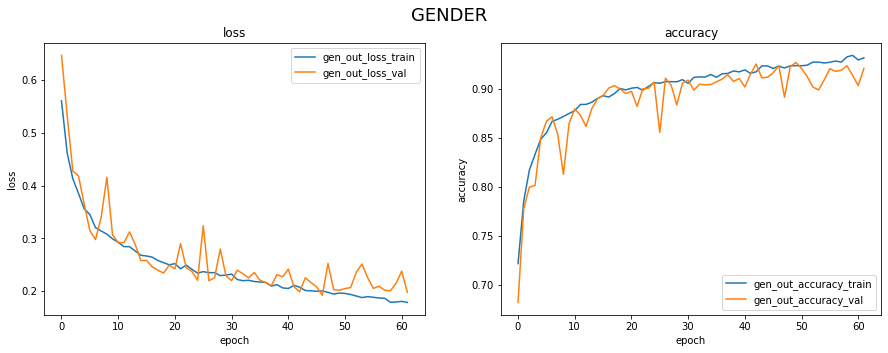

In [41]:
fig = plt.figure(figsize=(15, 5))

plt.suptitle('GENDER', fontsize=18)

# loss gender    
subplot = fig.add_subplot(1, 2, 1)
plt.plot(gen_model_history.history['loss'], label='gen_out_loss_train')
plt.plot(gen_model_history.history['val_loss'], label='gen_out_loss_val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('loss')

# mae gender
subplot = fig.add_subplot(1, 2, 2)
plt.plot(gen_model_history.history['accuracy'], label='gen_out_accuracy_train')
plt.plot(gen_model_history.history['val_accuracy'], label='gen_out_accuracy_val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy')
;

## Evaluate models

In [32]:
age_model.evaluate(x_test/255., y_test[:,0])

141/141 [==============================] - 12s 80ms/step - loss: 102.9879 - mae: 7.6971


[102.98794555664062, 7.697070598602295]

In [42]:
gen_model.evaluate(x_test/255., tf.keras.utils.to_categorical(y_test[:,1], num_classes=2))

141/141 [==============================] - 10s 69ms/step - loss: 0.1840 - accuracy: 0.9340


[0.1839897781610489, 0.9339853525161743]

## Predict model

In [43]:
def preprocess_and_predict(test_imgs, test_ages, test_genders, n_samples=25):
    fig = plt.figure(figsize=(15, 12))
    for i in range(n_samples):
        img = test_imgs[i]
        age = test_ages[i]
        gender = test_genders[i]
        
        img = img/255
        pred_age = age_model.predict(tf.expand_dims(img, axis=0))
        pred_gen = gen_model.predict(tf.expand_dims(img, axis=0))
        print(i, pred_age, pred_gen)
        subplot = fig.add_subplot(int(n_samples/5), 5, i+1)
        subplot.set_title(f'Gender_True: {gender} Age_True: {age}\n Gender_Pred: {np.argmax(pred_gen)} Age_Pred: {int(np.round(pred_age))}', fontsize=8)
        plt.axis('off')
        plt.imshow(img)
        
    return

0 [[36.02171]] [[6.431623e-05 9.999356e-01]]
1 [[32.085552]] [[9.9998486e-01 1.5083221e-05]]
2 [[39.78261]] [[2.1422300e-05 9.9997854e-01]]
3 [[72.45732]] [[9.999999e-01 7.553121e-08]]
4 [[38.876846]] [[1.0000000e+00 1.3352821e-15]]
5 [[55.56379]] [[9.9982774e-01 1.7224310e-04]]
6 [[39.244167]] [[1.000000e+00 7.749672e-09]]
7 [[21.606215]] [[4.2787433e-06 9.9999571e-01]]
8 [[21.308815]] [[9.993931e-01 6.069301e-04]]
9 [[47.08821]] [[3.4142729e-06 9.9999654e-01]]
10 [[32.90445]] [[0.00236532 0.99763465]]
11 [[54.26319]] [[1.0000000e+00 1.3298299e-08]]
12 [[44.602318]] [[1.7843702e-07 9.9999988e-01]]
13 [[43.159676]] [[0.8859413  0.11405873]]
14 [[40.890106]] [[0.9635142  0.03648583]]
15 [[37.538864]] [[1.000000e+00 1.502604e-08]]
16 [[0.]] [[0.49858245 0.5014175 ]]
17 [[4.2862883]] [[0.35734355 0.6426565 ]]
18 [[72.85826]] [[9.998714e-01 1.286326e-04]]
19 [[36.174816]] [[0.01456842 0.9854316 ]]
20 [[24.781055]] [[1.000000e+00 5.868908e-15]]
21 [[59.97492]] [[1.0000000e+00 4.7246325e-11]

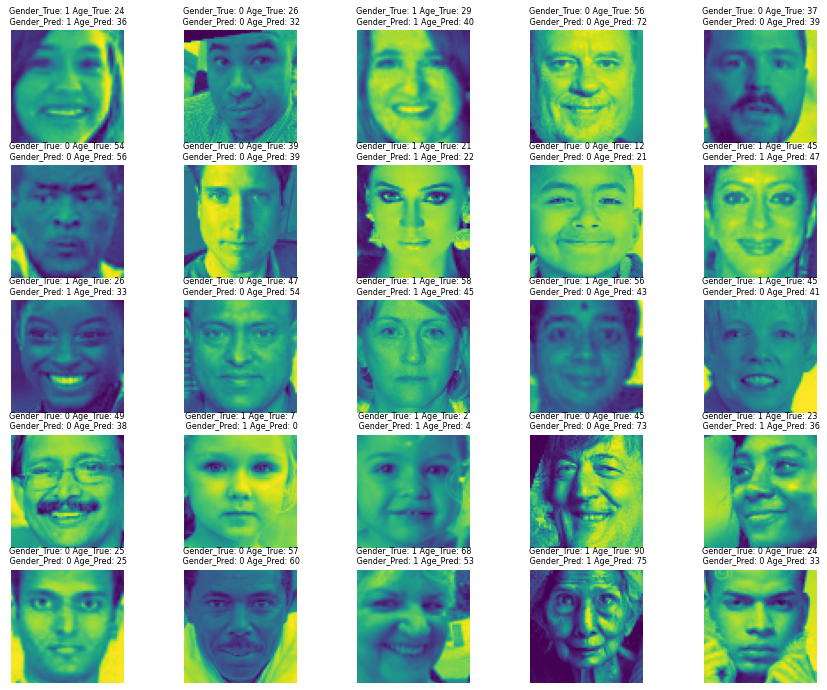

In [44]:
preprocess_and_predict(x_test[:25], y_test[:25,0], y_test[:25,1])